### Imports

In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch import nn

from domains.starDomain import Sphere
from pdeOperators.operators import *
from lossFuncitons.pinnLossFunctions import *
from lossFuncitons.pinnNeuralOperatorLoss import *
from neuralOperators.imposedBCNeuralOperator import *
from neuralOperators.classicalNeuralOperators import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np

%matplotlib widget

Problem is defined in the following way. Let $\Omega = B(0,1)$ be the open Ball with center at 0 and radius 1.
We want to find the solution of 

$\Delta u = 0, ~ \text{on } \Omega $ and 

$ u = f, \text{ on } \partial \Omega $

For some $f \in C( \partial \Omega )$

### Define some evaluation functions for which we know the analytic solution of the equation above

In [3]:
#these are some harmonic functions

def testFunc1(xy_grid):
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (torch.exp(x1)*torch.sin(x2)).view(-1,1)

def testFunc2(xy_grid):
    #this has a singularity at 0
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (torch.log(x1*x1 + x2*x2)).view(-1,1)

def testFunc3(xy_grid):
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (x1*x1 - x2*x2).view(-1,1)

def trainFunc(xy_grid,a,b,c):
    return a*testFunc1(xy_grid) + b*testFunc2(xy_grid) + c*testFunc3(xy_grid)

### Set Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate Domain and Data Points on ball and on boundary

In [5]:
#generate Points for training
domain  = Sphere(2,torch.tensor([2.,2.]), torch.tensor(1.),device)
ballPoints = domain.generateCartesianRandomPointsFullDomain(2000)
bdPoints = domain.generateSphericalRandomPointsOnBoundary(500)

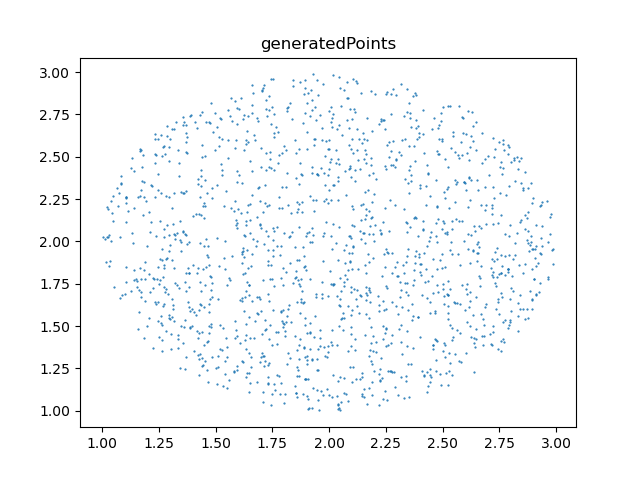

In [6]:
#plot generated points
pointsAsOneTensor = torch.cat(ballPoints, dim= 1).to("cpu")
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(pointsAsOneTensor[:,0],pointsAsOneTensor[:,1],s = 0.3)
plt.show()

### Define Models

In [9]:
createNewModel = True

if createNewModel:
    solOperatorImposed = ImposedBCDeepONetSphere2D_DBCtoSol(    
                                                n_hidden_trunk = 500,
                                                n_layers_trunk = 2,
                                                n_hidden_branch = 500,
                                                n_layers_branch = 3,
                                                domain = domain,
                                                nBoundaryPoints = 500
                                                )
else:
    solOperatorImposed = torch.load("./trainedModels/laplaceImposedDeepONet.pt")


In [10]:
createNewModel = True

if createNewModel:
    solOperatorClassical = DeepONet2D_DBCtoSol(    
                                    n_hidden_trunk = 500,
                                    n_layers_trunk = 2,
                                    n_hidden_branch = 500,
                                    n_layers_branch = 3,
                                    boundaryPoints = bdPoints
                                                    )
else:
    solOperatorClassical = torch.load("./trainedModels/laplaceClassicalDeepONet.pt")

### Setting for Training

#### Setting for Training Imposed DeepONet

In [12]:
xy_grid = ballPoints
xy_grid[0].requires_grad = True
xy_grid[1].requires_grad = True
bdPoints[0].requires_grad = True
bdPoints[1].requires_grad = True
epochs = 10000
learningRate  = 1e-4
boundaryFunctionBatchSize = 20

In [13]:
#move everything to right device
xy_grid[0] = xy_grid[0].to(device)
xy_grid[1] = xy_grid[1].to(device)
bdPoints[0] = bdPoints[0].to(device)
bdPoints[1] = bdPoints[1].to(device)
print()

In [14]:
#define optimizer
optimizerImposed = torch.optim.Adam(solOperatorImposed.parameters(), lr = learningRate)
optimizerClassical = torch.optim.Adam(solOperatorClassical.parameters(), lr = learningRate)

## Training

### Trainig ImposedDeepONet

In [15]:
# move model to device
solOperatorImposed.updateDevice(device)

In [16]:
#computes initial loss to see where we start
loss = laplaceEquationLossOperator(solOperatorImposed, xy_grid, lambda grid : trainFunc(grid,1,1,1), device = device )
minLossImposed = loss.item()
minLossImposed

37.14208593652933

In [17]:
#training
for i in range(epochs):
    optimizerImposed.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand = torch.rand(3)*2
    loss = laplaceEquationLossOperator(solOperatorImposed, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand), device = device )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand = torch.rand(3) *2
        loss = loss + laplaceEquationLossOperator(solOperatorImposed, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand), device = device )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossImposed:
        minLossImposed = loss.item()
        torch.save(solOperatorImposed, "./trainedModels/laplaceImposedDeepONet.pt")
    if i%10 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerImposed.step()

epoch 0
44.34603938805476
epoch 10
16.69947550505513
epoch 20
16.20463314453063
epoch 30
12.612070966435796
epoch 40
11.329182532231158
epoch 50
10.477952549102156
epoch 60
11.471003958175997
epoch 70
10.322027638801002
epoch 80
11.275157447666103
epoch 90
8.238934062582798
epoch 100
8.29397713724588
epoch 110
11.583177777635445
epoch 120
7.21305648344906
epoch 130
7.354452256874261
epoch 140
7.320157419042591
epoch 150
7.587603762848857
epoch 160
7.418520787260099
epoch 170
6.9318596289505185
epoch 180
6.088764781785229
epoch 190
6.2706602353186325
epoch 200
7.408579788043809
epoch 210
5.388195348256545
epoch 220
6.236746685904421
epoch 230
5.419282756868909
epoch 240
5.965303558513802
epoch 250
5.080925547555378
epoch 260
6.247795370488262
epoch 270
4.441046632133252
epoch 280
5.145644992459037
epoch 290
7.212410402547532
epoch 300
4.8479181119998875
epoch 310
7.502617047697509
epoch 320
5.94596956878388
epoch 330
6.112204304026099
epoch 340
4.815388319774162
epoch 350
4.874661151795

In [18]:
# move model to cpu
solOperatorImposed.updateDevice("cpu")

### Training classical DeepONet

In [19]:
# move model to device
solOperatorClassical.updateDevice(device)

In [20]:
#computes initial loss to see where we start
loss = laplaceEquationLossOperator(solOperatorClassical, xy_grid, lambda grid : trainFunc(grid,1,1,1),boundaryPoints = bdPoints, device = device, beta = 1 )
minLossClassical = loss.item()
minLossClassical

9.507387747429492

In [21]:
#training
for i in range(epochs):
    solOperatorClassical.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand = torch.rand(3)*2
    loss = laplaceEquationLossOperator(solOperatorClassical, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand),boundaryPoints = bdPoints, device = device, beta = 10  )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand = torch.rand(3) *2
        loss = loss + laplaceEquationLossOperator(solOperatorClassical, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand),boundaryPoints = bdPoints, device = device, beta = 10  )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossClassical:
        minLossClassical = loss.item()
        torch.save(solOperatorClassical, "./trainedModels/laplaceClassicalDeepONet.pt")
    if i%10 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerClassical.step()

epoch 0
100.63197589000661
epoch 10
48.2482359775032
epoch 20
39.10860052091203
epoch 30
43.17297944194693
epoch 40
32.72880885968565
epoch 50
30.41227598119138
epoch 60
31.888896883657164
epoch 70
27.223367563815287
epoch 80
24.899290483083234
epoch 90
32.20317289486494
epoch 100
22.439282531252385
epoch 110
48.73083098463062
epoch 120
29.962185682916544
epoch 130
19.951093091081304
epoch 140
19.27627942239582
epoch 150
16.737870867229343
epoch 160
15.642377896031764
epoch 170
23.432817025307223
epoch 180
20.387733544067064
epoch 190
14.2514809194341
epoch 200
17.367511227195575
epoch 210
21.645081726134364
epoch 220
13.900776396918975
epoch 230
21.628583467351778
epoch 240
13.286743237168677
epoch 250
12.625610408003656
epoch 260
16.87946779443341
epoch 270
15.895829123814977
epoch 280
13.32660381217567
epoch 290
13.775866096445965
epoch 300
14.859453496100134
epoch 310
12.082797502429834
epoch 320
10.545366286968655
epoch 330
24.18558689077272
epoch 340
10.197374755988086
epoch 350


In [22]:
# move model to device
solOperatorClassical.updateDevice("cpu")

### Visualize/Evaluate

In [23]:
xy_grid[0] = xy_grid[0].to("cpu")
xy_grid[1] = xy_grid[1].to("cpu")

#### Mix of Test Functions

In [58]:
#test with mix test function:
coeffs = torch.rand(3)*2
coeffs[0],coeffs[1],coeffs[2] = 1, -1,0
myTestFunc = lambda grid : trainFunc(grid,coeffs[0],coeffs[1],coeffs[2])

neuralOpOutImposed_Mix = solOperatorImposed(xy_grid, myTestFunc)
neuralOpOutClassical_Mix = solOperatorClassical(xy_grid, myTestFunc)
#laplacianImposed_Mix = laplacian(neuralOpOutImposed_Mix, xy_grid, device = "cpu")
#laplacianClassical_Mix = laplacian(neuralOpOutClassical_Mix, xy_grid, device = "cpu")
trueOut = trainFunc([xy_grid[0], xy_grid[1]],coeffs[0],coeffs[1],coeffs[2])

absDifferenceTrueImposed = torch.abs(trueOut - neuralOpOutImposed_Mix)
absDifferenceTrueClassical = torch.abs(trueOut - neuralOpOutClassical_Mix)

errorImposed = torch.norm(absDifferenceTrueImposed)
errorClassical = torch.norm(absDifferenceTrueClassical)

maxErrorImposed = torch.max(absDifferenceTrueImposed)
maxErrorClassical = torch.max(absDifferenceTrueClassical)

In [59]:
#print errors
print(f"L2 Error of classical DeepONet:                        {errorClassical }")
print(f"L2 Error of DeepONet with imposed Dirichlet condition: {errorImposed }")

print(f"Max Error of classical DeepONet:                        {maxErrorClassical}")
print(f"Max Error of DeepONet with imposed Dirichlet condition: {maxErrorImposed}")

L2 Error of classical DeepONet:                        17.07816505432129
L2 Error of DeepONet with imposed Dirichlet condition: 0.9325501322746277
Max Error of classical DeepONet:                        0.7086424827575684
Max Error of DeepONet with imposed Dirichlet condition: 0.05050992965698242


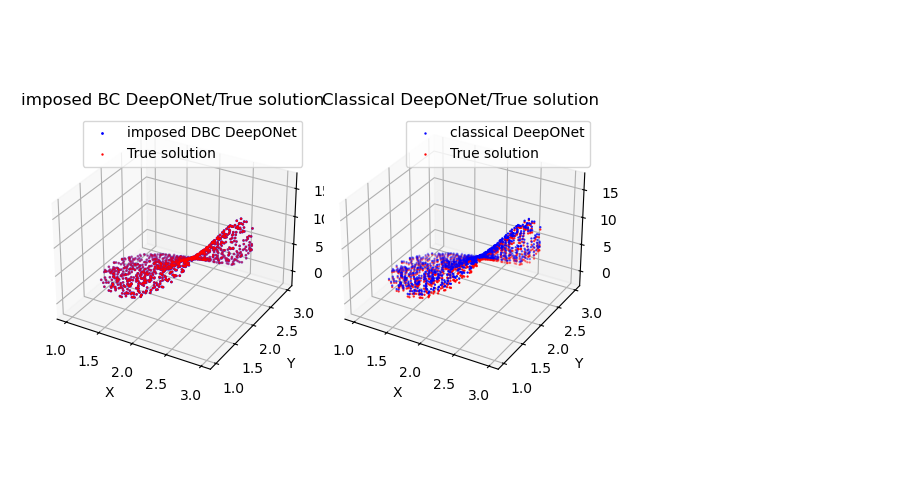

In [60]:
numPointsPlot = min(1000, xy_grid[0].shape[0])

x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()

zImposedDeepONet = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()
zClassicalDeepONet = neuralOpOutClassical_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')

#set labels 
axS3D1.set_title('imposed BC DeepONet/True solution')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')


axS3D2.set_title('Classical DeepONet/True solution')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')





# Plot the surface
axS3D1.scatter(x, y, zImposedDeepONet, c= "blue", s = 1)
axS3D1.scatter(x,y,ztrue, c = 'red' , s = 0.5)
axS3D1.legend(['imposed DBC DeepONet', 'True solution'])

axS3D2.scatter(x, y, zClassicalDeepONet, c = 'blue', s = 0.5)
axS3D2.scatter(x,y,ztrue, c = 'red', s = 0.5 )
axS3D2.legend(['classical DeepONet', 'True solution'])



# Show plot
plt.tight_layout()
plt.show()

In [195]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])

data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = zClassicalDeepONet[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with x1^2-x2^2 on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

TypeError: Cannot interpret '-1' as a data type

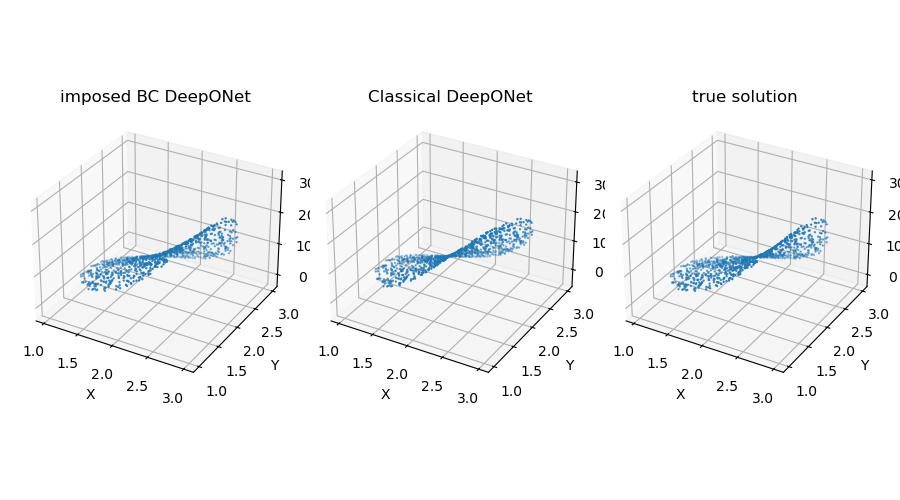

In [61]:
numPointsPlot = min(1000, xy_grid[0].shape[0])

x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()

zImposedDeepONet = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()
zClassicalDeepONet = neuralOpOutClassical_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()


figS3D = plt.figure(figsize=(9, 5))
# Create a 3D plot
axS3D1 = figS3D.add_subplot(131, projection='3d')
axS3D2 = figS3D.add_subplot(132, projection='3d')
axS3D3 = figS3D.add_subplot(133, projection='3d')

#set labels 
axS3D1.set_title('imposed BC DeepONet')
axS3D1.set_xlabel('X')
axS3D1.set_ylabel('Y')

axS3D2.set_title('Classical DeepONet')
axS3D2.set_xlabel('X')
axS3D2.set_ylabel('Y')

axS3D3.set_title('true solution')
axS3D3.set_xlabel('X')
axS3D3.set_ylabel('Y')


# Plot the surface
axS3D1.scatter(x, y, zImposedDeepONet , s = 0.5)
axS3D2.scatter(x, y, zClassicalDeepONet, s = 0.5)
axS3D3.scatter(x, y, ztrue, s = 0.5)



# Show plot
plt.tight_layout()
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_20568\3874768985.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_20568\3874768985.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


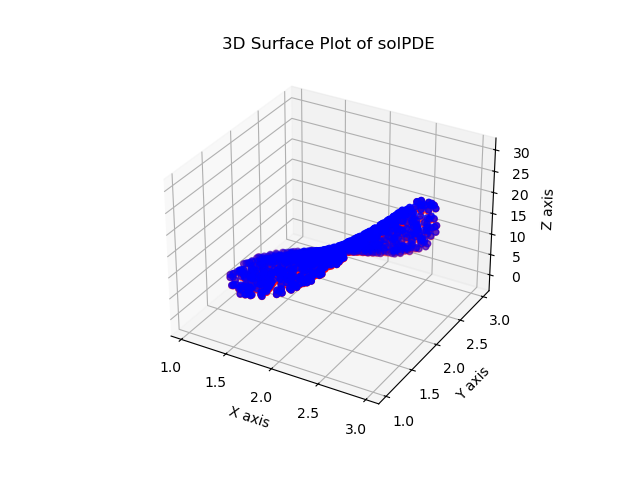

In [63]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = trueOut[:numPointsPlot].to("cpu").view(-1).detach().numpy()



z = neuralOpOutImposed_Mix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()